<a href="https://colab.research.google.com/github/Diavatly54/GeoMachine_project/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
# Load the Dirve helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Set up packages

In [1]:
import torch
import numpy as np
import torch.nn as nn

import torch.nn.functional as F

import matplotlib.pyplot as plt
#from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import argparse

## 2. Set up parameters for training model

In [5]:
torch.manual_seed(30)
np.random.seed(30)

epochs          = 500
learning_rate   = 0.002
scheduler_step  = 30
scheduler_gamma = 0.1
sub             = 1
ntrain          = 90
ntest           = 10
T_in            = 50
T_end           = 350
S               = 104
batch_size      =  5
mode1           = 12
mode2           = 12
width           = 15
step            = 300

## 3. Fourier layer

In [6]:
################################################################
# fourier layer
################################################################
class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1/(self.in_channels*self.out_channels*1000)) # here 10 means the dx and dz
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))

        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, \
                                                             self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft_x = torch.fft.rfft2(x)
        x_ft_z = torch.fft.rfft2(torch.transpose(x,2,3))

        # Multiply relevant Fourier modes
        out_ft_x = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, \
                             dtype=torch.cfloat, device=x.device)
        out_ft_z = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, \
                             dtype=torch.cfloat, device=x.device)
        out_ft_x[:, :, :self.modes1, :self.modes2]  = self.compl_mul2d(x_ft_x[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft_x[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft_x[:, :, -self.modes1:, :self.modes2], self.weights2)


        out_ft_z[:, :, :self.modes1, :self.modes2]  = self.compl_mul2d(x_ft_z[:, :, :self.modes1, :self.modes2], self.weights3)
        out_ft_z[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft_z[:, :, -self.modes1:, :self.modes2], self.weights4)

        #Return to physical space
        out_ft_x = torch.fft.irfft2(out_ft_x, s=(x.size(-2), x.size(-1)))
        out_ft_z = torch.fft.irfft2(out_ft_z, s=(x.size(-2), x.size(-1)))
        #print("this is the shape of the out_x", out_ft_x.shape)
        #print("this is the shape of the out_z", out_ft_z.shape)

        return out_ft_x, out_ft_z

## 4. FNO model

In [7]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear((50+5), self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv4 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv5 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv6 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)


        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)

        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)
        self.bn4 = torch.nn.BatchNorm2d(self.width)
        self.bn5 = torch.nn.BatchNorm2d(self.width)
        self.bn6 = torch.nn.BatchNorm2d(self.width)

        self.fc1 = nn.Linear(self.width, 300)
        #self.fc2 = nn.Linear(200, args.step)

    def forward(self, x , C1, C2, C3):
        batchsize = x.shape[0]

        size_x, size_y = x.shape[1], x.shape[2]

        C1 = torch.reshape(C1,[batchsize,1,size_x,size_y])
        C2 = torch.reshape(C2,[batchsize,1,size_x,size_y])
        C3 = torch.reshape(C3,[batchsize,1,size_x,size_y])

        C1 = torch.nn.functional.normalize(C1)
        C2 = torch.nn.functional.normalize(C2)
        C3 = torch.nn.functional.normalize(C3)

        C1 = torch.reshape(C1,[batchsize,size_x,size_y,1])
        C2 = torch.reshape(C2,[batchsize,size_x,size_y,1])
        C3 = torch.reshape(C3,[batchsize,size_x,size_y,1])

        grid = self.get_grid(batchsize, size_x, size_y, x.device)
        '''
        print("this is the shape of x",     x.shape)
        print("this is the shape of grid ", grid.shape)
        print("this is the shape of C1 ",   C1.shape)
        print("this is the shape of C2 ",   C2.shape)
        print("this is the shape of C3 ",   C3.shape)
        '''
        x = torch.cat((x, grid, C1, C2, C3), dim=-1)
        #print("this is the shape od x ",x.shape)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x0, z0 = self.conv0(x)
        xw_0   = self.w0(x)
        #print("this is the shape of the wx0", xw_0.shape)
        x      = self.bn0(xw_0 + x0 + z0 )
        x = F.relu(x)

        x1, z1 = self.conv1(x)
        xw_1   = self.w1(x)
        x      = self.bn1(xw_1 + x1 + z1 + x)
        x = F.relu(x)

        x2, z2 = self.conv2(x)
        xw_2   = self.w2(x)
        x      = self.bn2(xw_2 + x2 + z2 + x)
        x = F.relu(x)


        x3, z3 = self.conv3(x)
        xw_3   = self.w3(x)
        x      = self.bn3(xw_3 + x3 + z3 + x)
        x = F.relu(x)

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        #x = F.relu(x)
        #x = self.fc2(x)

        return x

    def get_grid(self, batchsize, size_x, size_y, device):
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

## 5. Define tensor pad to define Perfectly matching layer for boundary conditions

In [8]:
def tensor_pad(input_tensor,npad, freeSurface,dtype):
    """
    This function is to padding velocity tensor for implementing the absorbing boudary condition.
        input_tensor: is a 3D tensor, shape=[1, self.in_channels, self.nz, self.nx]
        output_tensor: is also a 3D tensor, shape=[1, self.in_channels, self.nz_pad, self.nx_pad]
    """
    nz,nx = input_tensor.shape[0],input_tensor.shape[1]
    input_tensor = input_tensor.reshape(1,1,nz,nx)
    #print("this is input tensor shape", input_tensor.shape)

    nz_pad = nz + 2* npad
    nx_pad = nx + 2* npad
    in_channels = 1

    if freeSurface:
        vpadTop = input_tensor
    else:
        vtop = torch.ones((1, in_channels, npad, nx),dtype = dtype) * input_tensor[:,:,0,:]
        vpadTop = torch.cat((vtop,input_tensor), -2) #padding on axis=2 (nz)

    vbottom = torch.ones((1, in_channels, npad, nx),dtype = dtype) * input_tensor[:,:,-1,:]
    vpadBottom = torch.cat([vpadTop,vbottom], -2)#padding on axis=2 (nz)

    vleft = torch.ones((1, in_channels, nz_pad, npad),dtype = dtype) * \
    vpadBottom[:,:,:,0].view(1, in_channels, -1, 1)
    vpadLeft = torch.cat([vleft,vpadBottom], -1)#padding on axis=3 (nx)

    vright = torch.ones((1, in_channels, nz_pad, npad),dtype= dtype) * \
    vpadBottom[:,:,:,-1].view(1,in_channels, -1, 1)
    output_tensor = torch.cat([vpadLeft,vright], -1)#padding on axis=3 (nx)

    return output_tensor

## 6. Load data for training operator

In [9]:
# load data into environment
import scipy.io
import torch

TRAIN_PATH = '/content/drive/MyDrive/MACHINE_LEARNING_IN_GEOSCIENCES/Final_project'
# load dat
tmp2=scipy.io.loadmat(TRAIN_PATH+'/Vx_test.mat')
tmp3=scipy.io.loadmat(TRAIN_PATH+'/Vs_train.mat')
tmp4=scipy.io.loadmat(TRAIN_PATH+'/Vs_test.mat')
tmp5=scipy.io.loadmat(TRAIN_PATH+'/Vp_train.mat')
tmp6=scipy.io.loadmat(TRAIN_PATH+'/Vp_test.mat')
tmp7=scipy.io.loadmat(TRAIN_PATH+'/rho_train.mat')
tmp8=scipy.io.loadmat(TRAIN_PATH+'/rho_test.mat')

In [10]:
# load Vx_train data # too heavy so I have separate into 9 part
import scipy.io
import torch
tmp11=scipy.io.loadmat(TRAIN_PATH+'/Vx_train1.mat')
# load other part of data
tmp12=scipy.io.loadmat(TRAIN_PATH+'/Vx_train2.mat')
tmp13=scipy.io.loadmat(TRAIN_PATH+'/Vx_train3.mat')
tmp14=scipy.io.loadmat(TRAIN_PATH+'/Vx_train4.mat')
tmp15=scipy.io.loadmat(TRAIN_PATH+'/Vx_train5.mat')
tmp16=scipy.io.loadmat(TRAIN_PATH+'/Vx_train6.mat')
tmp17=scipy.io.loadmat(TRAIN_PATH+'/Vx_train7.mat')
tmp18=scipy.io.loadmat(TRAIN_PATH+'/Vx_train8.mat')
tmp19=scipy.io.loadmat(TRAIN_PATH+'/Vx_train9.mat')

In [11]:
tensor_list = [tmp11['Vx_train1'], tmp12['Vx_train2'], tmp13['Vx_train3'],tmp14['Vx_train4'],tmp15['Vx_train5'],tmp16['Vx_train6'],tmp17['Vx_train7'],tmp18['Vx_train8'],tmp19['Vx_train9']]  # mỗi tensor shape: (10, 800, 104, 104)

result = np.concatenate(tensor_list, axis=0)

In [13]:
# convert numpy data to tensor in pytorch to input the model.

# test data torch.from_numpy()
vx_training = torch.from_numpy(result.astype(np.float32))

vp_index_training  = torch.from_numpy(tmp5['Vp_train'].astype(np.float32))
vs_index_training  = torch.from_numpy(tmp3['Vs_train'].astype(np.float32))
rho_index_training =torch.from_numpy(tmp7['rho_train'].astype(np.float32))


# training data
vx_testing =  torch.from_numpy(tmp2['Vx_test'].astype(np.float32))

vp_index_testing  = torch.from_numpy(tmp6['Vp_test'].astype(np.float32))
vs_index_testing  = torch.from_numpy(tmp4['Vs_test'].astype(np.float32))
rho_index_testing = torch.from_numpy(tmp8['rho_test'].astype(np.float32))

print("this is the shape of the original size",vp_index_training.shape)
print("this is the shape of the fields",vx_training.shape)
print("this is the shape of the original size",vp_index_testing.shape)
print("this is the shape of the fields",vx_testing.shape)

vp_index_training  = vp_index_training[:,:,:].reshape(90,64,64,1)
vs_index_training  = vs_index_training[:,:,:].reshape(90,64,64,1)
rho_index_training = rho_index_training[:,:,:].reshape(90,64,64,1)

vp_index_testing  = vp_index_testing[:,:,:].reshape(10,64,64,1)
vs_index_testing  = vs_index_testing[:,:,:].reshape(10,64,64,1)
rho_index_testing = rho_index_testing[:,:,:].reshape(10,64,64,1)

this is the shape of the original size torch.Size([90, 64, 64])
this is the shape of the fields torch.Size([90, 800, 104, 104])
this is the shape of the original size torch.Size([10, 64, 64])
this is the shape of the fields torch.Size([10, 800, 104, 104])


In [14]:
# padding the input data to mimic the boundary condition
vp_index_training_reshape   = torch.zeros(90,104,104)
vs_index_training_reshape   = torch.zeros(90,104,104)
rho_index_training_reshape  = torch.zeros(90,104,104)

vp_index_testing_reshape   = torch.zeros(10,104,104)
vs_index_testing_reshape   = torch.zeros(10,104,104)
rho_index_testing_reshape  = torch.zeros(10,104,104)


for i_model_index in range(90):
    vp_index_reshape_i = tensor_pad(vp_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    vp_index_training_reshape[i_model_index,:,:] = vp_index_reshape_i.squeeze()
    vs_index_reshape_i = tensor_pad(vs_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    vs_index_training_reshape[i_model_index,:,:] = vs_index_reshape_i.squeeze()
    rho_index_reshape_i = tensor_pad(rho_index_training[i_model_index,:,:,:], 20, False, torch.float32)
    rho_index_training_reshape[i_model_index,:,:] = rho_index_reshape_i.squeeze()

for i_model_index in range(10):
    vp_index_reshape_i = tensor_pad(vp_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    vp_index_testing_reshape[i_model_index,:,:] = vp_index_reshape_i.squeeze()
    vs_index_reshape_i = tensor_pad(vs_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    vs_index_testing_reshape[i_model_index,:,:] = vs_index_reshape_i.squeeze()
    rho_index_reshape_i = tensor_pad(rho_index_testing[i_model_index,:,:,:], 20, False, torch.float32)
    rho_index_testing_reshape[i_model_index,:,:] = rho_index_reshape_i.squeeze()

In [15]:
vp_index_training_reshape =  vp_index_training_reshape.reshape(90,104,104,1)
vs_index_training_reshape =  vs_index_training_reshape.reshape(90,104,104,1)
rho_index_training_reshape = rho_index_training_reshape.reshape(90,104,104,1)

vp_index_testing_reshape =  vp_index_testing_reshape.reshape(10,104,104,1)
vs_index_testing_reshape =  vs_index_testing_reshape.reshape(10,104,104,1)
rho_index_testing_reshape = rho_index_testing_reshape.reshape(10,104,104,1)

In [16]:
runtime = np.zeros(2, )
t1 = default_timer()

In [17]:
print("this is the shape of vx_train", vx_training.shape)
#print("this is the shape of vx_train", vz_train.shape)
vx_training = vx_training.permute(0,2,3,1)
vx_testing  = vx_testing.permute(0,2,3,1)

print(vx_training.shape)
print(vx_testing.shape)

this is the shape of vx_train torch.Size([90, 800, 104, 104])
torch.Size([90, 104, 104, 800])
torch.Size([10, 104, 104, 800])


In [18]:
train_a = vx_training[:,::sub,::sub,:T_in]
train_u = vx_training[:,::sub,::sub,T_in:T_end]

train_vp  =  vp_index_training_reshape[:,::sub,::sub,:]
train_vs  =  vs_index_training_reshape[:,::sub,::sub,:]
train_rho  = rho_index_training_reshape[:,::sub,::sub,:]

test_a  = vx_testing[:,::sub,::sub,:T_in]
test_u  = vx_testing[:,::sub,::sub,T_in:T_end]

test_vp  = vp_index_testing_reshape [:,::sub,::sub,:]
test_vs  = vs_index_testing_reshape [:,::sub,::sub,:]
test_rho = rho_index_testing_reshape[:,::sub,::sub,:]

In [19]:
print("this is the training_set of of a", train_a.shape)
print("this is the training_set of of u", train_u.shape)
print("this is the training_set of of vp",  train_vp.shape)
print("this is the training_set of of vs",  train_vs.shape)
print("this is the training_set of of rho", train_rho.shape)

print("this is the testing_set of of a", test_a.shape)
print("this is the testing_set of of u", test_u.shape)

print("this is the testing_set of of vp",  test_vp.shape)
print("this is the testing_set of of vs",  test_vs.shape)
print("this is the testing_set of of rho", test_rho.shape)

this is the training_set of of a torch.Size([90, 104, 104, 50])
this is the training_set of of u torch.Size([90, 104, 104, 300])
this is the training_set of of vp torch.Size([90, 104, 104, 1])
this is the training_set of of vs torch.Size([90, 104, 104, 1])
this is the training_set of of rho torch.Size([90, 104, 104, 1])
this is the testing_set of of a torch.Size([10, 104, 104, 50])
this is the testing_set of of u torch.Size([10, 104, 104, 300])
this is the testing_set of of vp torch.Size([10, 104, 104, 1])
this is the testing_set of of vs torch.Size([10, 104, 104, 1])
this is the testing_set of of rho torch.Size([10, 104, 104, 1])


In [20]:
print(train_u.shape)
assert (S            == train_u.shape[-2])
assert (300          == train_u.shape[-1])

assert (S            == test_u.shape[-2])
assert (300          == test_u.shape[-1])

assert (S == train_vp.shape[-2])
assert (S == train_vs.shape[-2])
assert (S == train_rho.shape[-2])

assert (S == test_vp.shape[-2])
assert (S == test_vs.shape[-2])
assert (S == test_rho.shape[-2])

torch.Size([90, 104, 104, 300])


In [21]:
train_a = train_a.reshape(90, S, S, 50)
train_u = train_u.reshape(90, S, S, 300)
test_a  = test_a.reshape (10, S, S, 50)
test_u  = test_u.reshape (10, S, S, 300)

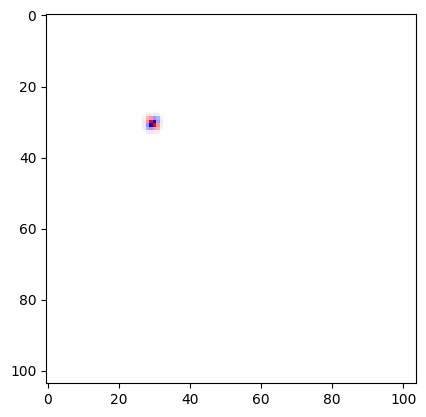

In [22]:
plt.imshow(test_a[2,:,:,30],cmap='bwr_r')
# print(test_a[2,:,:,30])

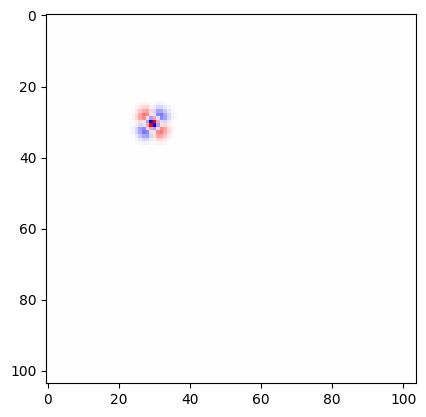

In [23]:
plt.imshow(test_u[9,:,:,30],cmap='bwr_r')
# print(test_u[9,:,:,30])

In [24]:
# separate data into train and testing set
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u,\
                                                                          train_vp,train_vs,train_rho), \
                                                                          batch_size = batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u, \
                                                                          test_vp,test_vs,test_rho), \
                                                                          batch_size = batch_size, shuffle=True)

## 7. training operator

In [25]:
device = torch.device('cuda')
print("this is the devide we are using device \n", device)
model = FNO2d(mode1, mode2, width).cuda()

this is the devide we are using device 
 cuda


In [26]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

In [27]:
import torch
import torch.nn as nn

class LpLoss(nn.Module):
    def __init__(self, p=2, size_average=True):
        super(LpLoss, self).__init__()
        self.p = p
        self.size_average = size_average

    def forward(self, x, y):
        loss = torch.norm(x - y, p=self.p)
        if self.size_average:
            loss = loss / x.numel()
        return loss


In [28]:
print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)

training_loss_tensor = torch.zeros(epochs)
testing_loss_tensor  = torch.zeros(epochs)

#myloss = LpLoss(size_average=False)
myloss = LpLoss(p=2, size_average=False)

costFunc = torch.nn.MSELoss(reduction='sum')
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step_training = 0
    test_l2_step_testing = 0
    for xx, yy, C1, C2, C3 in train_loader:
        #print("this the the loading of training loader")
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)
        C1 = C1.to(device)
        C2 = C2.to(device)
        C3 = C3.to(device)

        for t in range(0, (T_end - T_in),step):
            y = yy[..., t:t + step]
            #print("this is the shape of y",y.shape)
            im_train = model(xx,C1,C2,C3)
            #loss += costFunc(im_train,y)
            loss += myloss(im_train.reshape(batch_size, -1), y.reshape(batch_size, -1))
            if t == 0:
                pred = im_train
            else:
                pred = torch.cat((pred, im_train), -1)

            xx = torch.cat((xx[..., step:], im_train), dim=-1)

            #print("this is the shape of xx ======>", xx.shape)
        #print("this before loss backpropagation")
        train_l2_step_training += loss.item()
        #l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        #train_l2_full += l2_full.item()

        optimizer.zero_grad()
        loss.backward()
        #print("this is the loss ====== >", loss)
        #print("this is the epoch====== >", ep)
        optimizer.step()
        training_loss_tensor[ep] = train_l2_step_training

    test_l2_step = 0
    test_l2_full = 0

    with torch.no_grad():
        for xx, yy, C1, C2, C3 in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            C1 = C1.to(device)
            C2 = C2.to(device)
            C3 = C3.to(device)

            for t in range(0, (T_end - T_in),step):
                y = yy[..., t:t + step]
                im_test = model(xx,C1,C2,C3)
                #loss += costFunc(im_test,y)
                loss += myloss(im_test.reshape(batch_size, -1), y.reshape(batch_size, -1))
                if t == 0:
                    pred = im_test
                else:
                    pred = torch.cat((pred, im_test), -1)

                xx = torch.cat((xx[..., step:], im_test), dim=-1)

            test_l2_step_testing += loss.item()
            #test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
            testing_loss_tensor[ep] = test_l2_step_testing

    t2 = default_timer()
    #scheduler.step()
    print("current epock",ep, \
          "processing time in each iteration [{:.4e}]".format(t2 - t1), \
          "training loss [{:.4e}]".format(train_l2_step_training), \
          "testing loss  [{:.4e}]".format(test_l2_step_testing))

914730
current epock 0 processing time in each iteration [3.1795e+00] training loss [2.4103e+04] testing loss  [1.5661e+03]
current epock 1 processing time in each iteration [1.8659e+00] training loss [9.9950e+03] testing loss  [7.6136e+02]
current epock 2 processing time in each iteration [2.3385e+00] training loss [5.6261e+03] testing loss  [5.0759e+02]
current epock 3 processing time in each iteration [1.9229e+00] training loss [4.1141e+03] testing loss  [3.9906e+02]
current epock 4 processing time in each iteration [1.8540e+00] training loss [3.4297e+03] testing loss  [3.4937e+02]
current epock 5 processing time in each iteration [1.8886e+00] training loss [3.1314e+03] testing loss  [3.2933e+02]
current epock 6 processing time in each iteration [1.8616e+00] training loss [2.9982e+03] testing loss  [3.1820e+02]
current epock 7 processing time in each iteration [1.8884e+00] training loss [2.9313e+03] testing loss  [3.1339e+02]
current epock 8 processing time in each iteration [1.9540

In [29]:
torch.save(testing_loss_tensor,   TRAIN_PATH+'/testing_loss_'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')
torch.save(training_loss_tensor,  TRAIN_PATH+'/training_loss_'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')
torch.save(model.state_dict(),    TRAIN_PATH+'/model_OCFNO_Huu'+str(width)+'_'+str(mode1)+'_'+str(mode2)+'_.pt')

In [30]:
im_plot_train  = im_train[2,:,:,200].cpu().clone().detach().numpy()
im_plot_tests  = im_test [3,:,:,100].cpu().clone().detach().numpy()

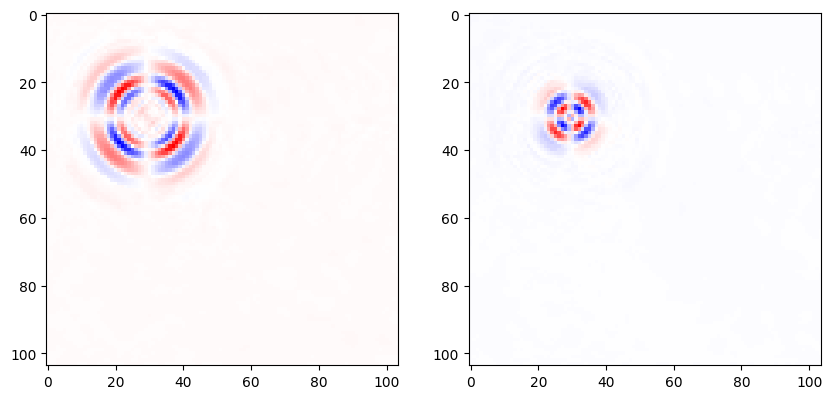

In [31]:
fig = plt.figure(figsize = (10,10)) # create the canvas for plotting
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(im_plot_train, cmap='bwr_r')
ax2 = plt.subplot(1, 2, 2)
ax2.imshow(im_plot_tests, cmap='bwr_r')

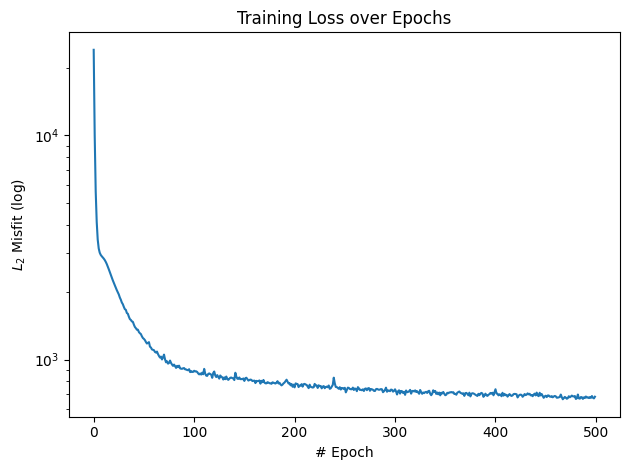

In [32]:
plt.plot(training_loss_tensor)
plt.yscale('log')
plt.title('Training Loss over Epochs')
plt.xlabel('# Epoch')           # Trục x là số epoch
plt.ylabel(r'$L_2$ Misfit (log)')
plt.tight_layout()
plt.show()

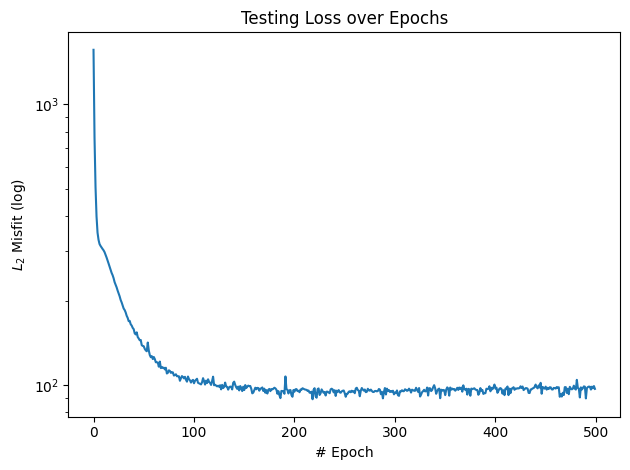

In [33]:
plt.plot(testing_loss_tensor)
plt.yscale('log')
plt.title('Testing Loss over Epochs')
plt.xlabel('# Epoch')           # Trục x là số epoch
plt.ylabel(r'$L_2$ Misfit (log)')
plt.tight_layout()
plt.show()

## 8. Predict the wavefield

In [34]:
# Load the Dirve helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os
os.chdir(r"/content/drive/MyDrive/MACHINE_LEARNING_IN_GEOSCIENCES/Final_project")

In [36]:
os.listdir()

['Vs_test.mat',
 'rho_test.mat',
 'Vp_test.mat',
 'Vs_train.mat',
 'rho_train.mat',
 'Vp_train.mat',
 'Vx_test.mat',
 'Vx_train1.mat',
 'Vx_train2.mat',
 'Vx_train3.mat',
 'Vx_train4.mat',
 'Vx_train5.mat',
 'Vx_train6.mat',
 'Vx_train7.mat',
 'Vx_train8.mat',
 'Vx_train9.mat',
 'Vx_out_com.mat',
 'Vx_in.mat',
 'rho_predict.mat',
 'Vp_predict.mat',
 'Vs_predict.mat',
 'testing_loss_15_12_12_.pt',
 'training_loss_15_12_12_.pt',
 'model_OCFNO_Huu15_12_12_.pt',
 'Final_project.ipynb']

In [38]:
tp1=scipy.io.loadmat(TRAIN_PATH+'/Vx_in.mat')
tp2=scipy.io.loadmat(TRAIN_PATH+'/Vx_out_com.mat')
tp3=scipy.io.loadmat(TRAIN_PATH+'/Vp_predict.mat')
tp4=scipy.io.loadmat(TRAIN_PATH+'/Vs_predict.mat')
tp5=scipy.io.loadmat(TRAIN_PATH+'/rho_predict.mat')

In [41]:
vx_in = torch.from_numpy(tp1['Vx_in'].astype(np.float32))
#vx_out_com = vx_out_com.permute(0,2,3,1)
vx_out_com = torch.from_numpy(tp2['Vx_out_com'].astype(np.float32))

vp_predict  = torch.from_numpy(tp3['Vp_predict'].astype(np.float32))
vs_predict = torch.from_numpy(tp4['Vs_predict'].astype(np.float32))
rho_predict =torch.from_numpy(tp5['rho_predict'].astype(np.float32))

In [44]:
vp_ = tensor_pad(vp_predict, 20, False, torch.float32)
vs_ = tensor_pad(vs_predict, 20, False, torch.float32)
rho_ = tensor_pad(rho_predict, 20, False, torch.float32)

In [140]:
vp_in_pre =  vp_.reshape(1,104,104,1)
vs_in_pre =  vs_.reshape(1,104,104,1)
rho_in_pre = rho_.reshape(1,104,104,1)
vsh = vx_in.permute(1,2,0)
vshshape =  vsh.reshape(1,104,104,50)

In [146]:
# run to get the prediction
model = model.to('cpu')
import time

start = time.time()
VxOCFNO = model(vshshape,vp_in_pre,vs_in_pre,rho_in_pre)

time.sleep(2)

end = time.time()
print(f"Wavefield calculation time: {end - start:.4f} seconds")

Wavefield calculation time: 2.0334 seconds


In [147]:
VxOCFNO = VxOCFNO.reshape(104,104,300)
VxOCFNO = VxOCFNO.detach().cpu().numpy()
VxOCFNO.shape

(104, 104, 300)

In [148]:
vx_in.shape
vx_fno = vx_in.permute(1,2,0)
vx_fno.shape

torch.Size([104, 104, 50])

In [149]:
# get the predicted data from seismic and from ftdt
t1list = [vx_in, vx_out_com]

vxftdt = np.concatenate(t1list, axis=0)
vxft = vxftdt.transpose(1,2,0)

# get the predicted data from seismic and from ftdt
t2list = [vx_fno, VxOCFNO]

vxFNO = np.concatenate(t2list, axis=2)

## 9. Plot the wavefield from FTDT and from OCFNO

<ipython-input-150-45f9a11587d7>:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


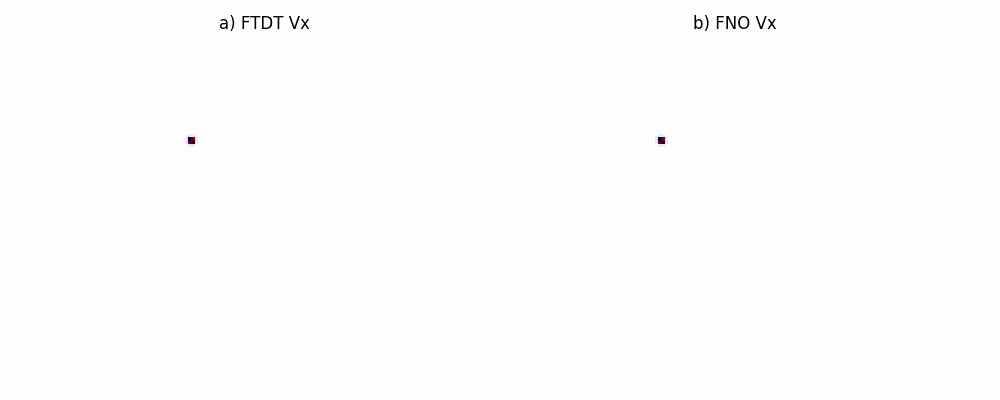

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from IPython.display import Image

# Create folder to store frames
os.makedirs("frames", exist_ok=True)

# Normalize for consistent color range
#vmin = min(vxft.min(), vxFNO.min())
#vmax = max(vxft.max(), vxFNO.max())

# Loop through time steps and save frames
for t in range(vxft.shape[2]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].imshow(vxft[:, :, t], cmap='seismic') #, vmin=vmin, vmax=vmax)
    axs[0].set_title("a) FTDT Vx")
    axs[0].axis('off')

    axs[1].imshow(vxFNO[:, :, t], cmap='seismic') #, vmin=vmin, vmax=vmax)
    axs[1].set_title("b) FNO Vx")
    axs[1].axis('off')

    plt.tight_layout()
    plt.savefig(f"frames/frame_{t:03d}.png")
    plt.close()

    # Create GIF from saved frames
with imageio.get_writer('Vx_comparison.gif', mode='I', duration=0.1) as writer:
    for t in range(vxft.shape[2]):
        filename = f"frames/frame_{t:03d}.png"
        image = imageio.imread(filename)
        writer.append_data(image)

    # Display the GIF
Image(filename='Vx_comparison.gif')